In [5]:
# Input parameters
X0 = 110.; σ = 0.25; r = 0.02; K = 100; B = 115; T = 0.5; β = 0.75; m = 2

In [2]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

def Explicit_FDM_CEV(σ, r, K, B, T, Nx, β, m=2):  
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    # Stability condition on size of time step
    Δt = 0.9 / σ**2 / Nx**2        
    # Convert steps to integer
    Nt = int(T/Δt)
    # Recalibrate Δt based on number of steps
    Δt = T / Nt 
    # Initial Condition requires an addition step to set prices below x=120 to zero
    V = np.maximum(xs-K, 0) 
    V[0:int(B/Δx)] = 0   # int truncates the decimal part so this index corresponds to x<B i.e. anything below barrier

    # Set up matrix diagonals
    d0 = 1 - σ**2 * np.power(xs,2*β)*Δt/Δx**2 - r*Δt
    d1 = 0.5*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2*β)*Δt/Δx**2)
    dm1 = 0.5*(σ**2 * np.power(xs[1:],2*β)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)
  
    # Boundary condition for small asset price
    d0[0] = (1 - r * Δt) 
    d1[0] = 0
    
    # Construct the matrix
    A = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    for t in range(Nt):
        V = A.dot(V) 
        V[-1] = 2.*V[-2] - V[-3] # Boundary condition for large asset price
    
    return V, xs

Nx = 5000; # step size for asset price
V1, xs1 = Explicit_FDM_CEV(σ, r, K, B, T, Nx, β, m)
print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.2%}'.format(X0, V1[int(X0*Nx/(m*K))] / X0))

Option price as a percentage of spot at x0 = 110 is 4.35%
Wall time: 17.8 s


In [3]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

def Option(σ, r, K, B, T, Nx, β, m=2):  
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    # Stability condition on size of time step
    Δt = 0.9 / σ**2 / Nx**2        
    # Convert steps to integer
    Nt = int(T/Δt)
    # Initial Condition requires an addition step to set prices above x=120 to zero
    V = np.maximum(xs-K, 0) 
    V[0:int(B/Δx)] = 0   

    # Set up matrix diagonals
    d0 = 1 - σ**2 * np.power(xs,2*β)*Δt/Δx**2 - r*Δt
    d1 = 0.5*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2*β)*Δt/Δx**2)
    dm1 = 0.5*(σ**2 * np.power(xs[1:],2*β)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)
    
    # Boundary condition for small asset price
    d0[0] = (1 - r * Δt) 
    d1[0] = 0
    
    # Construct the matrix
    A = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    for t in range(Nt):
        V = A.dot(V)
        V[-1] = 2.*V[-2] - V[-3] # Boundary condition for large asset price
    
    return V, Δx, Δt

def Richardson(σ, r, K, B, T, Nx, β, m=2):
    # 1st solution vector with Nx asset steps
    V1, Δx1, Δt1 = Option(σ, r, K, B, T, Nx, β, m)
    # 2nd solution vector with double the asset steps
    V2, Δx2, Δt2 = Option(σ, r, K, B, T, int(Nx*2), β, m) 
    xs = np.linspace(0, m*K, Nx+1)
    # return solution vector adjusted with Richardson's Extrapolation
    return (4.*V2[::2] - V1) / 3., xs

Nx = 1600
V2, xs2 = Richardson(σ, r, K, B, T, Nx, β, m)
print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.2%}'.format(X0, V2[int(X0*Nx/(m*K))] / X0))

Option price as a percentage of spot at x0 = 110 is 4.35%
Wall time: 7.29 s


In [4]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def Crank_Nicolson_FDM_CEV(σ, r, K, B, T, Nx, Nt, β, m=2):  
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    # Initial Condition requires an addition step to set prices above x=120 to zero
    V = np.maximum(xs-K, 0) 
    V[0:int(B/Δx)] = 0   

    # Set up RHS matrix diagonals
    d0 = 1 + 0.5*(-σ**2 * np.power(xs,2.*β)*Δt/Δx**2 - r*Δt)
    d1 = 0.25*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2.*β)*Δt/Δx**2)
    dm1 = 0.25*(σ**2 * np.power(xs[1:],2.*β)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)
    # Boundary condition for small asset price
    d0[0] = 1
    d1[0] = 0
    # Boundary condition for large asset price
    d0[-1] = 0
    dm1[-1] = 0
    B = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)

    # Set up LHS matrix diagonals
    d0 = 2-d0
    d1 = -d1
    dm1 = -dm1
    dm2 = np.zeros(Nx-1)
    
    # Boundary condition for small asset price
    d0[0] = 1/(1 - r * Δt) 
    d1[0] = 0
    # Boundary condition for large asset price
    d0[-1] = 1
    dm1[-1] = -2
    dm2[-1] = 1
    # Construct LHS matrix
    A = diags([dm2,dm1,d0,d1], [-2,-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    A = A.tocsr()    
    for t in range(Nt):
        V = B.dot(V)
        V = spsolve(A,V)
  
    return V, xs

Nx = 5000; Nt = 500
V3, xs3 = Crank_Nicolson_FDM_CEV(σ, r, K, B, T, Nx, Nt, β, m)
print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.2%}'.format(X0, V3[int(X0*Nx/(m*K))] / X0))

Option price as a percentage of spot at x0 = 110 is 4.35%
Wall time: 1.76 s


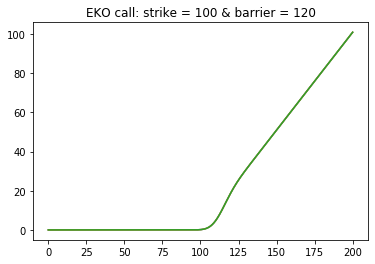

In [21]:
%matplotlib inline

plt.plot(xs1, V1, xs2, V2, xs3, V3)
plt.title("EKO call: strike = 100 & barrier = 120");